<a href="https://colab.research.google.com/github/E22CSEU1553/Energy-Demand-Forecasting/blob/main/Energy_Demand_Forecasting_Using_SARIMA(1553%2C1125).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.23.5 pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is inc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import shapiro
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Load the data

In [ ]:
data = pd.read_csv('/content/TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


# Data Preprocessing
# Convert utc_timestamp to datetime and set as index

In [ ]:
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Handle missing values

In [ ]:
print("Missing values before filling:")
print(data.isnull().sum())

Missing values before filling:
IT_load_new            72
IT_solar_generation     0
dtype: int64


# Fill missing values using forward fill

In [ ]:
data['IT_load_new'] = data['IT_load_new'].ffill()
data['IT_solar_generation'] = data['IT_solar_generation'].ffill()

print("\nMissing values after filling:")
print(data.isnull().sum())


Missing values after filling:
IT_load_new            0
IT_solar_generation    0
dtype: int64


# Exploratory Data Analysis

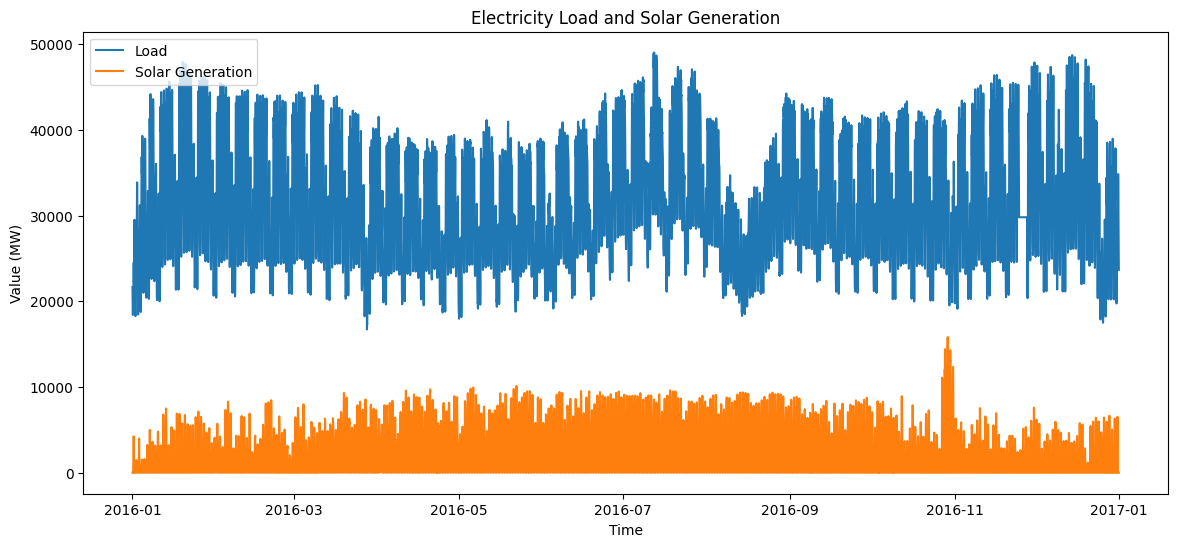

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(data.index, data['IT_load_new'], label='Load')
plt.plot(data.index, data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value (MW)')
plt.legend()
plt.title('Electricity Load and Solar Generation')
plt.show()

# Plot weekly patterns

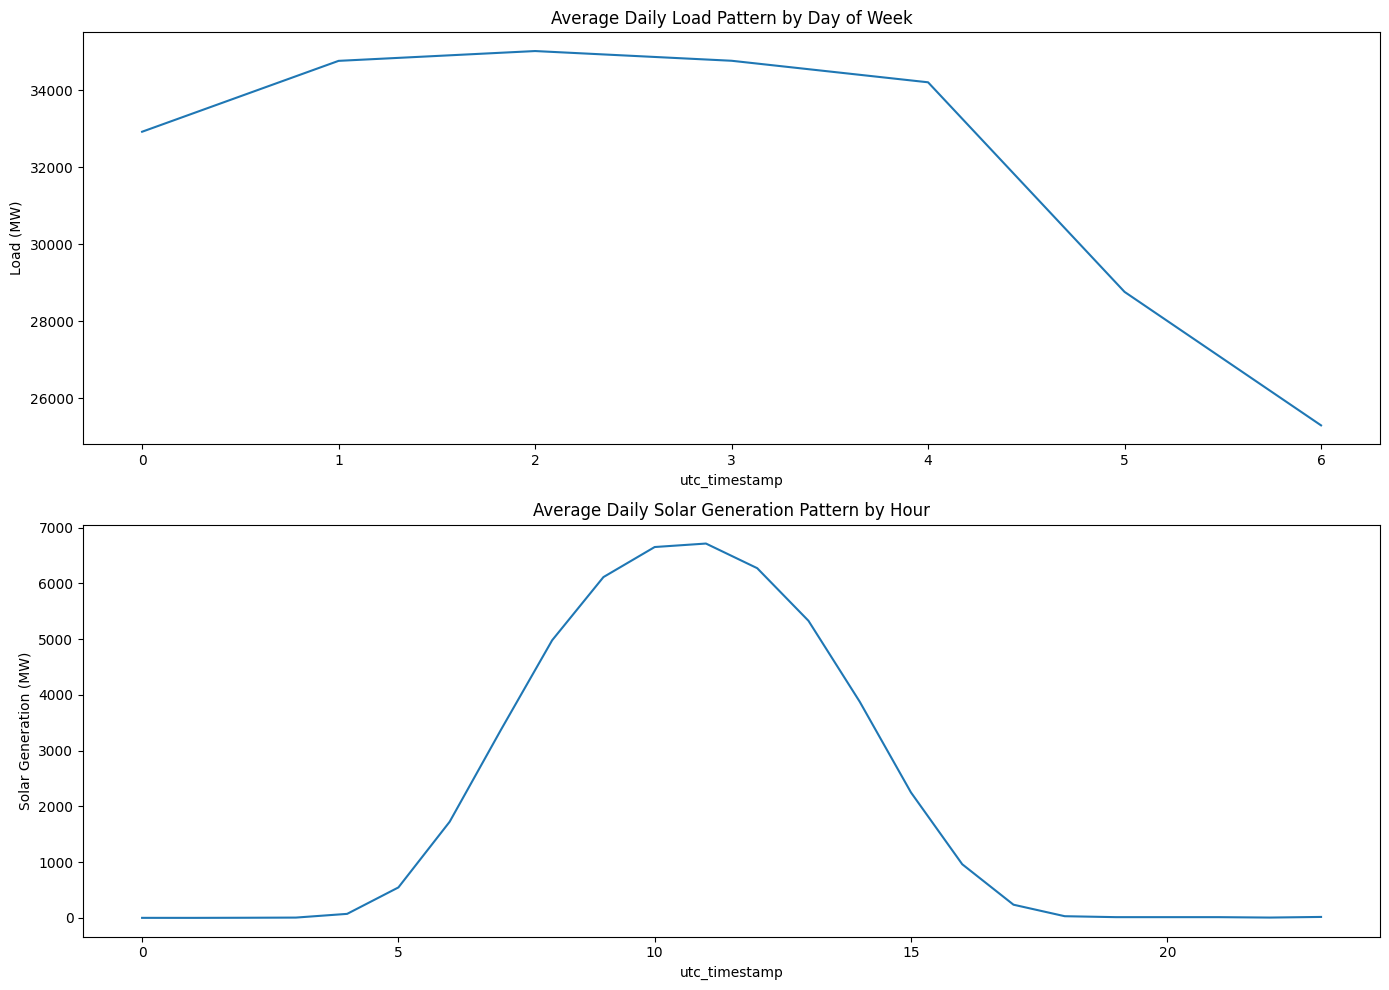

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))
data['IT_load_new'].groupby(data.index.dayofweek).mean().plot(ax=ax1)
ax1.set_title('Average Daily Load Pattern by Day of Week')
ax1.set_ylabel('Load (MW)')

data['IT_solar_generation'].groupby(data.index.hour).mean().plot(ax=ax2)
ax2.set_title('Average Daily Solar Generation Pattern by Hour')
ax2.set_ylabel('Solar Generation (MW)')
plt.tight_layout()
plt.show()

# Stationarity Check

In [ ]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

print("ADF test for 'IT_load_new':")
adf_test(data['IT_load_new'])

print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])

ADF test for 'IT_load_new':
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


# Seasonal Decomposition
# Decompose IT_load_new data (weekly seasonality)

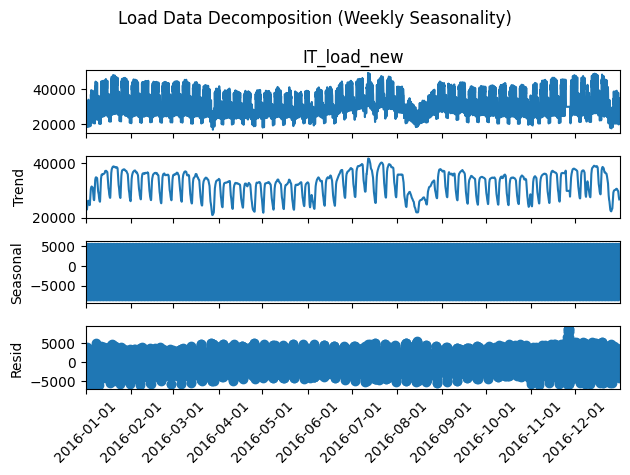

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


result_load = seasonal_decompose(data['IT_load_new'], model='additive', period=24)


fig = result_load.plot()
plt.suptitle('Load Data Decomposition (Weekly Seasonality)')


axs = fig.axes
for ax in axs:

    ax.tick_params(axis='x', rotation=45)


    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


    ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()
plt.show()

# Decompose IT_Solar_Generation data (daily seasonality)

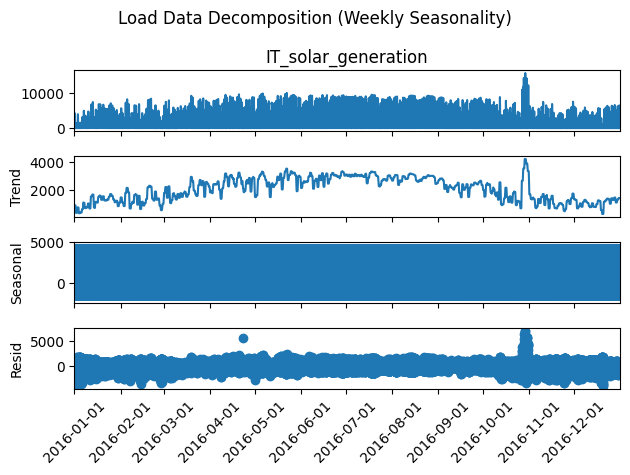

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

result_load = seasonal_decompose(data['IT_solar_generation'], model='additive', period=24)


fig = result_load.plot()
plt.suptitle('Load Data Decomposition (Weekly Seasonality)')


axs = fig.axes
for ax in axs:

    ax.tick_params(axis='x', rotation=45)


    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


    ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()
plt.show()

# Model Building - IT_load_new with SARIMA
# we'll use SARIMA(2,0,2)(2,0,2,24)

In [ ]:
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

model = SARIMAX(train,
                order=(2, 0, 2),
                seasonal_order=(2, 0, 2, 24))

model_fit_load = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Model summary and diagnostics

In [ ]:
print(model_fit_load.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        IT_load_new   No. Observations:                 7027
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood              -56635.870
Date:                            Tue, 06 May 2025   AIC                         113289.740
Time:                                    17:14:35   BIC                         113351.458
Sample:                                01-01-2016   HQIC                        113311.003
                                     - 10-19-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5580      0.005    316.315      0.000       1.548       1.568
ar.L2         -0.5728      0.004   

# Residual analysis

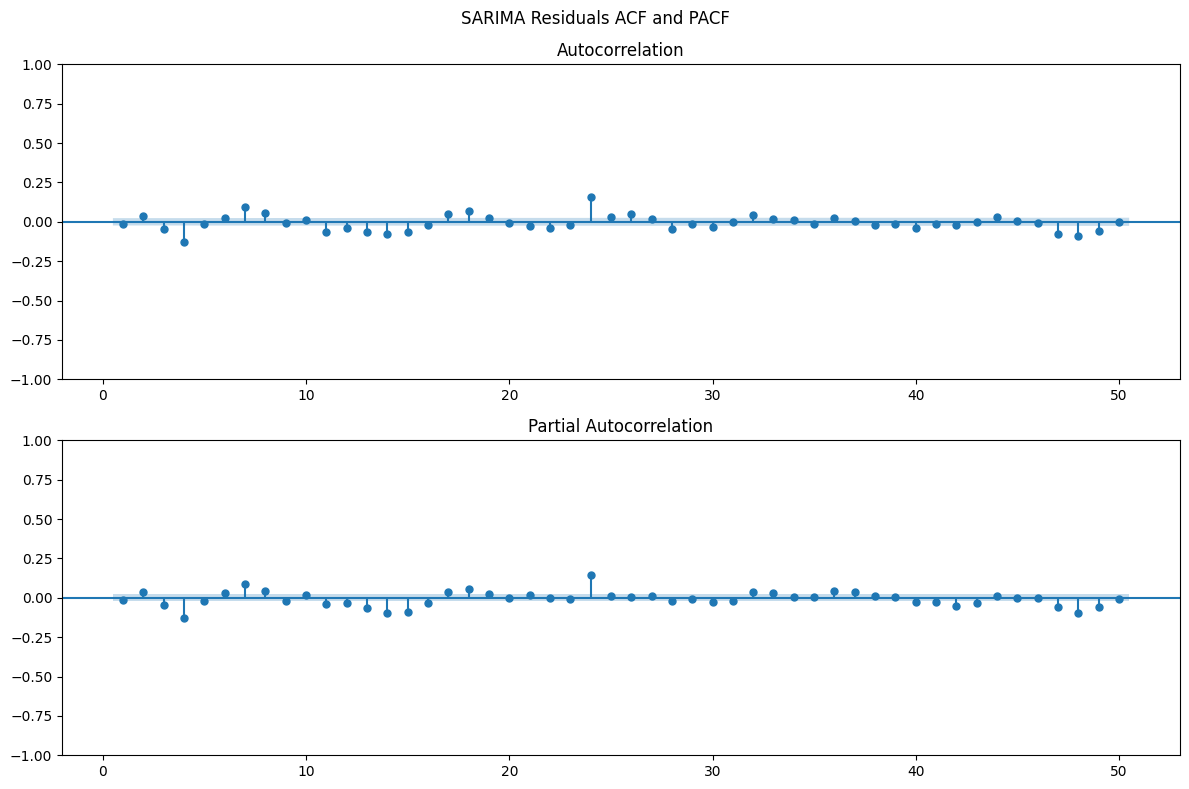

In [ ]:
residuals_load = model_fit_load.resid
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(residuals_load, lags=50, zero=False, ax=ax1)
plot_pacf(residuals_load, lags=50, zero=False, ax=ax2)
plt.suptitle("SARIMA Residuals ACF and PACF")
plt.tight_layout()
plt.show()

# Normality test of residuals

In [ ]:
stat, p = shapiro(residuals_load)
print(f'Shapiro-Wilk test for normality: statistic={stat:.4f}, p-value={p:.4f}')

Shapiro-Wilk test for normality: statistic=0.8445, p-value=0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7027.
  res = hypotest_fun_out(*samples, **kwds)


# Make predictions and calculate RMSE

In [ ]:
predictions_load = model_fit_load.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean
rmse_load = sqrt(mean_squared_error(test, predictions_load))
print(f'\nRMSE for load forecasting: {rmse_load:.2f}')


RMSE for load forecasting: 5502.50


# Plot actual vs predicted

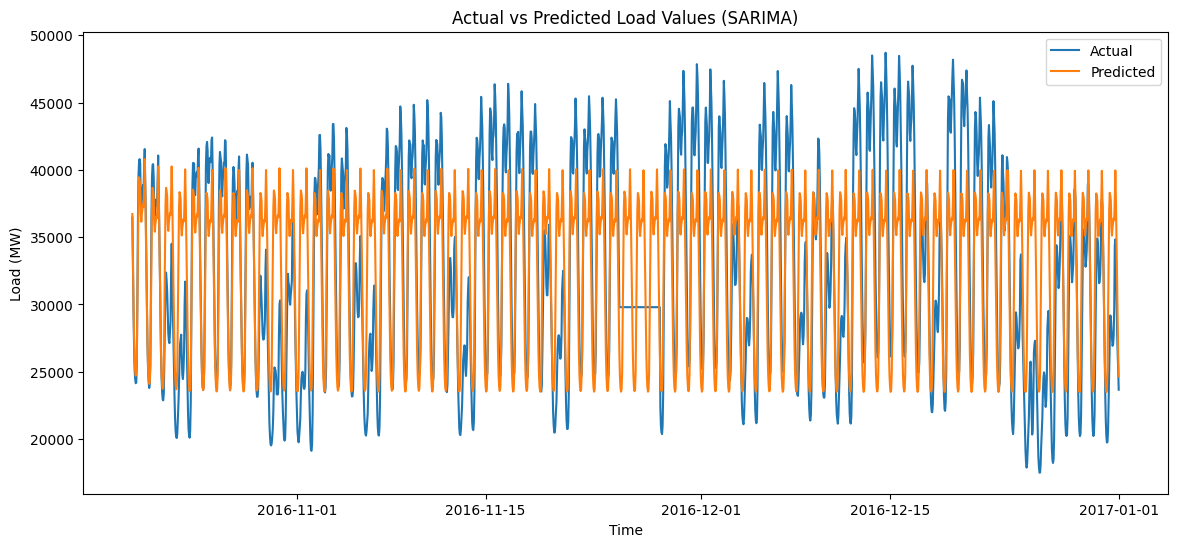

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions_load, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.title('Actual vs Predicted Load Values (SARIMA)')
plt.show()

# Model Building - IT_solar_generation with SARIMA
# we'll use SARIMA(2,0,2)(2,0,2,24)

In [ ]:
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

model_solar = SARIMAX(train,
order=(2, 0, 2),
seasonal_order=(2, 0, 2, 24))
model_fit_solar = model_solar.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


# Model summary and diagnostics

In [ ]:
print(model_fit_solar.summary())

                                     SARIMAX Results                                      
Dep. Variable:                IT_solar_generation   No. Observations:                 7027
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood              -49481.203
Date:                            Tue, 06 May 2025   AIC                          98980.406
Time:                                    17:22:46   BIC                          99042.123
Sample:                                01-01-2016   HQIC                         99001.668
                                     - 10-19-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0078      0.002     -4.053      0.000      -0.012      -0.004
ar.L2          0.9921      0.002   

# Residual analysis

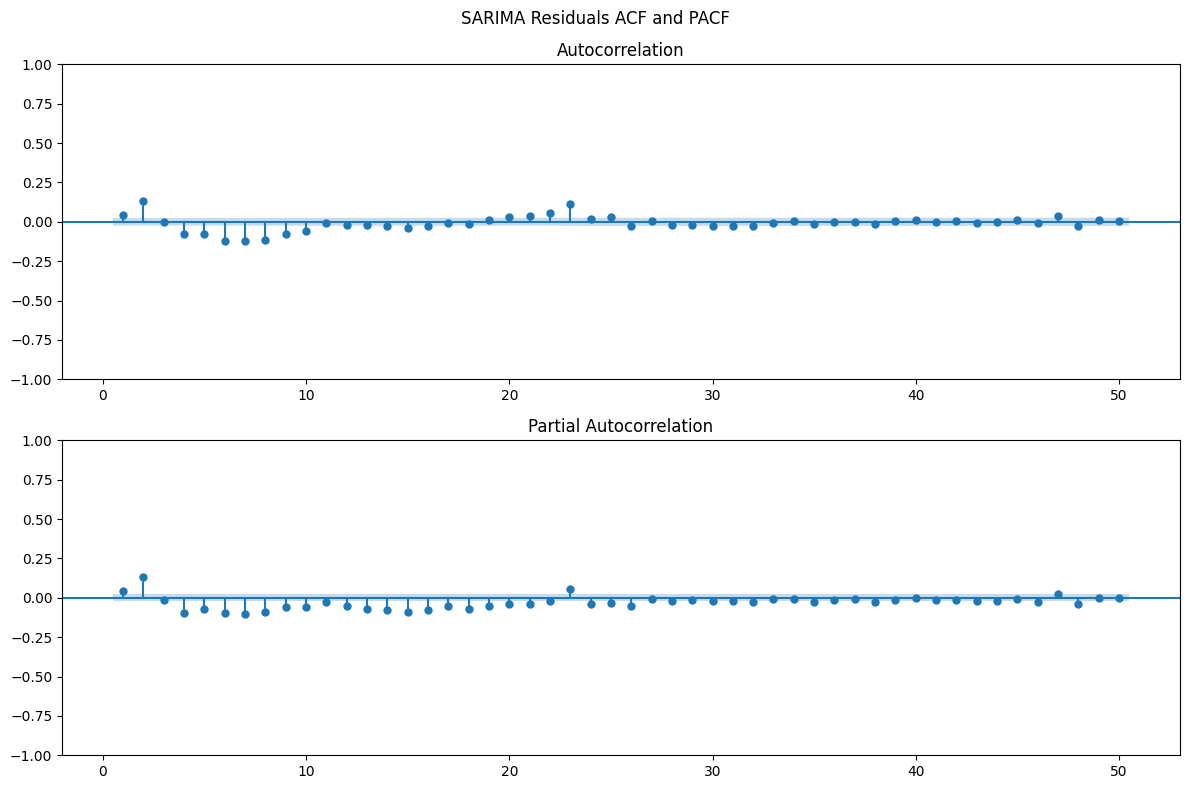

In [ ]:
residuals_solar = model_fit_solar.resid
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(residuals_solar, lags=50, zero=False, ax=ax1)
plot_pacf(residuals_solar, lags=50, zero=False, ax=ax2)
plt.suptitle("SARIMA Residuals ACF and PACF")
plt.tight_layout()
plt.show()

# Normality test of residuals

In [ ]:
stat, p = shapiro(residuals_solar)
print(f'Shapiro-Wilk test for normality: statistic={stat:.4f}, p-value={p:.4f}')

Shapiro-Wilk test for normality: statistic=0.7399, p-value=0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7027.
  res = hypotest_fun_out(*samples, **kwds)


# Make predictions and calculate RMSE

In [ ]:
predictions_solar = model_fit_solar.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean
rmse_solar = sqrt(mean_squared_error(test, predictions_solar))
print(f'\nRMSE for solar generation forecasting: {rmse_solar:.2f}')


RMSE for solar generation forecasting: 1234.66


# Plot actual vs predicted

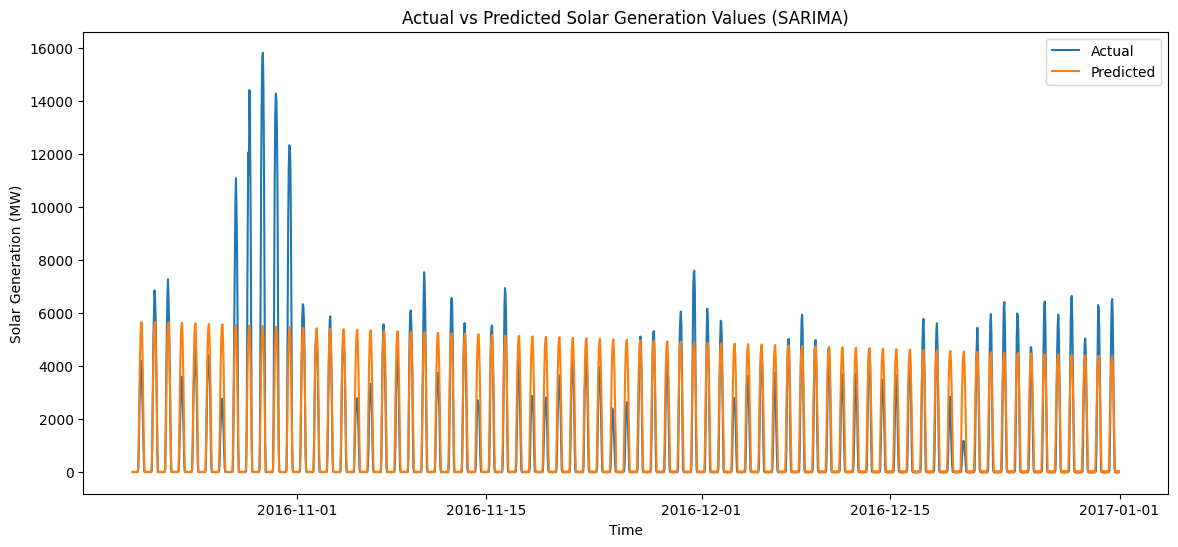

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions_solar, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Solar Generation (MW)')
plt.legend()
plt.title('Actual vs Predicted Solar Generation Values (SARIMA)')
plt.show()

# Future Forecasting Example
# Forecast 1 week ahead for IT_load_new Data


<ipython-input-23-844fd714aa9c>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(data.index[-1], periods=forecast_steps+1, freq='H')[1:]


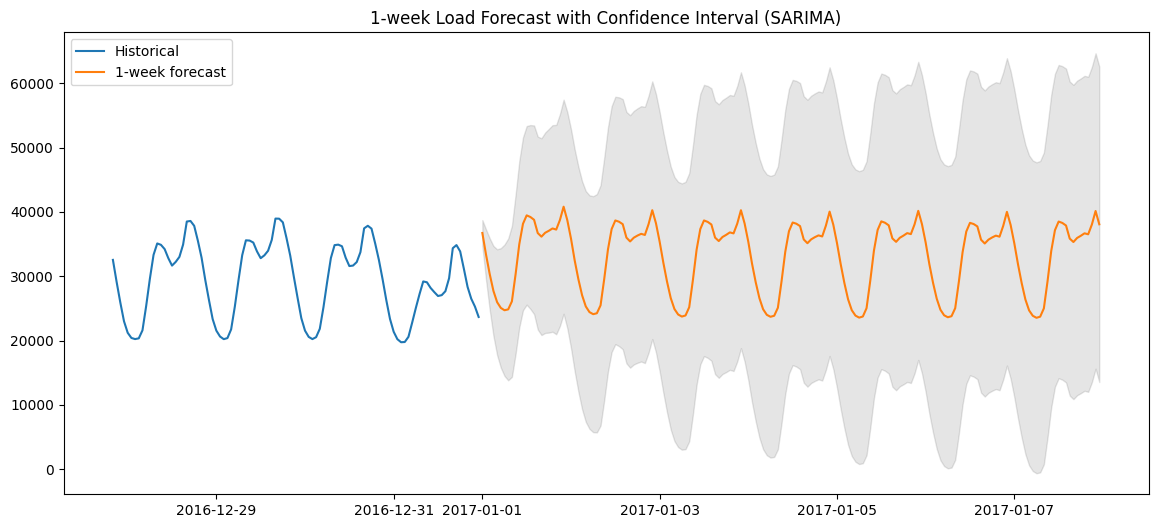

In [ ]:
forecast_steps = 24*7 # 1 week ahead
forecast_load = model_fit_load.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(data.index[-1], periods=forecast_steps+1, freq='H')[1:]

plt.figure(figsize=(14,6))
plt.plot(data.index[-100:], data['IT_load_new'][-100:], label='Historical')
plt.plot(forecast_index, forecast_load.predicted_mean, label='1-week forecast')
plt.fill_between(forecast_index,
forecast_load.conf_int()['lower IT_load_new'],
forecast_load.conf_int()['upper IT_load_new'],
color='k', alpha=0.1)
plt.legend()
plt.title('1-week Load Forecast with Confidence Interval (SARIMA)')
plt.show()

# Forecast 3 days ahead for IT_solar_generation data

<ipython-input-24-5e8719aca50b>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(data.index[-1], periods=forecast_steps+1, freq='H')[1:]


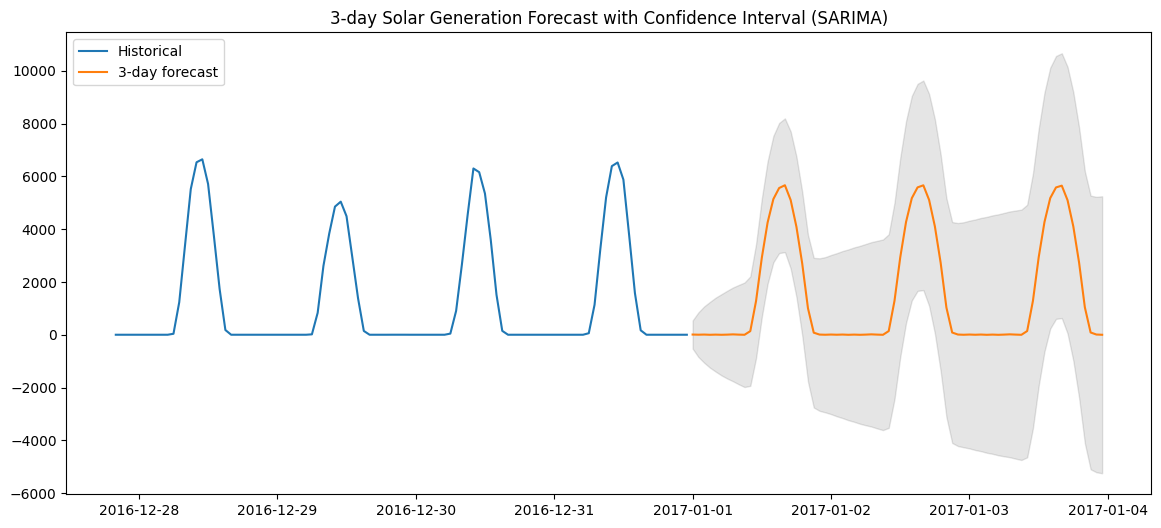

In [ ]:
forecast_steps = 24*3 # 3 days ahead
forecast_solar = model_fit_solar.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(data.index[-1], periods=forecast_steps+1, freq='H')[1:]

plt.figure(figsize=(14,6))
plt.plot(data.index[-100:], data['IT_solar_generation'][-100:], label='Historical')
plt.plot(forecast_index, forecast_solar.predicted_mean, label='3-day forecast')
plt.fill_between(forecast_index,
forecast_solar.conf_int()['lower IT_solar_generation'],
forecast_solar.conf_int()['upper IT_solar_generation'],
color='k', alpha=0.1)
plt.legend()
plt.title('3-day Solar Generation Forecast with Confidence Interval (SARIMA)')
plt.show()